In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True

import statsmodels.stats.weightstats as wsts

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [2]:
df = pd.read_csv('data/credit_card_default_analysis.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

### Визуальная и точечная оценка

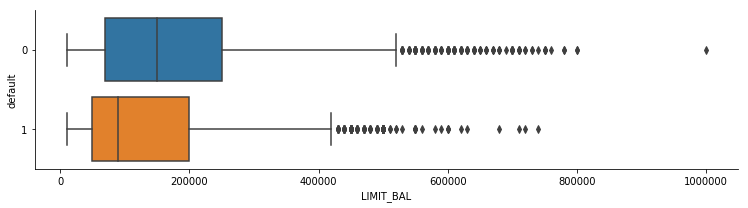

In [3]:
sns.catplot(data=df, x='LIMIT_BAL', y='default',
            kind='box', height=3, aspect=3.5,
            orient='h');

In [4]:
default0 = df[df.default == 0]
default1 = df[df.default == 1]

In [5]:
default0_lim = default0['LIMIT_BAL']
default1_lim = default1['LIMIT_BAL']

Оценим точечено. Видим, что в среднем кредитный лимит, у тех кто отдал кредит, был выше на 60к чем у тех, кто не отдал.

In [6]:
print(
    'Median limit balance difference',
    np.median(default0_lim) - np.median(default1_lim))

Median limit balance difference 60000.0


### Интервальная оценка бустрэпом

Чтобы построить интервальную оценку среднего, взглянем на распределения признака. Из гистограм видно, что распределение похоже на Пуассоновское, однако мы не уверены в этом, поэтому воспользуемся бустрапированной выборкой для интервальной оценки разности медиан выборок. Бустрап, благодаря своей универсальности позволяет делать оценки на неизвестных нам распределениях.

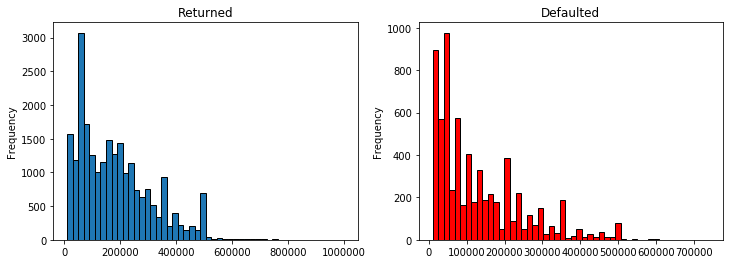

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(121)
df[df.default==0].LIMIT_BAL.plot(kind='hist', bins=50);
plt.title('Returned')
plt.subplot(122)
df[df.default==1].LIMIT_BAL.plot(kind='hist', bins=50, color='r');
plt.title('Defaulted');

In [8]:
def get_bootstrap_samples(data, n_samples):
    ints = np.random.randint(0, len(data), size=(n_samples, len(data)))
    return np.asarray(data)[ints]

In [9]:
def tolerance_int(stat, alpha):
    return np.percentile(stat, [100*alpha/2, 100*(1-alpha/2)])

In [10]:
default0_lim_boot = get_bootstrap_samples(default0_lim, 1000)
default1_lim_boot = get_bootstrap_samples(default1_lim, 1000)

In [11]:
default0_lim_med_scores = np.apply_along_axis(np.median, 1, default0_lim_boot)
default1_lim_med_scores = np.apply_along_axis(np.median, 1, default1_lim_boot)

In [12]:
def0_def1_lim_med_diffs = default0_lim_med_scores - default1_lim_med_scores

Как видно из интервальной оценки, в среднем у тех, кто отдаёт кредит кредитный лимит на 60000-70000 тысяч больше

In [13]:
print(tolerance_int(def0_def1_lim_med_diffs, 0.05))

[60000. 70000.]


Проверим гипотезу о равенстве распределений с помощью непараметрического критерия знаковых рангов Уилкоксона-Манна-Уитни для двух независимых выборок.

**Критерий:**
- Уилкоксона-Манна-Уитни

**Условия применимости:**
- [X] $n \ge 20$ in each sample

In [19]:
print(len(default0_lim), len(default1_lim))

23364 6636


**Гипотезы:**
- $H_0:$ Распределение кредитного баланса одинаково для тех кто вернул кредит и для тех кто не вернул
- $H_1:$ Распределения не одинаковы. Двусторонняя альтернатива.

In [18]:
print(len(default0_lim))
print(len(default1_lim))

23364
6636


In [14]:
 sc.stats.mannwhitneyu(default0_lim, default1_lim, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Проверим те же гипотезы при помощи перестановочного критерия.

UPD:
**Критерий:**
- Перестановочный для двух независимых выборок

**Условия применимости:** [вики](https://goo.gl/sDF7d)
- [X] В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
- [ ] В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).

Как видим, второе условие применимости не выполняется. Однако, в предыдущей итерации я уже применил его, и оставил вам небольшой бонус. Поэтому в анализе этот критерий игнорируем.

In [52]:
from collections import Counter
Counter(default1_lim)

Counter({20000: 698,
         120000: 179,
         70000: 210,
         450000: 26,
         60000: 233,
         50000: 885,
         210000: 117,
         150000: 187,
         500000: 81,
         200000: 270,
         10000: 197,
         320000: 44,
         30000: 568,
         240000: 110,
         360000: 154,
         80000: 363,
         310000: 27,
         180000: 176,
         170000: 78,
         130000: 157,
         100000: 272,
         190000: 49,
         140000: 170,
         220000: 89,
         260000: 87,
         460000: 10,
         280000: 69,
         300000: 95,
         110000: 132,
         230000: 113,
         380000: 20,
         160000: 137,
         390000: 18,
         270000: 28,
         600000: 3,
         620000: 1,
         90000: 166,
         290000: 53,
         40000: 92,
         470000: 11,
         250000: 51,
         410000: 12,
         340000: 32,
         350000: 32,
         400000: 31,
         550000: 6,
         440000: 12,
    

**Гипотезы:**
- $H_0:$ Распределение кредитного баланса одинаково для тех кто вернул кредит и для тех кто не вернул
- $H_1:$ Распределения не одинаковы. Двусторонняя альтернатива.

**Я собрал перестановочные функции от авторов курса в один файл. Он уже в архиве с ноутбуком. Чтобы всё работало, поместите файл в одну папку с ноутбуком. (скорее всего он уже там, если вы извлекли весь архив в одну папку)** 

Прошу прощения, если это доставит вам неудобство, но я надеялся, что в последствии этот минипакет сделает вашу жизнь удобнее, хотя бы в аспекте применения перестановочных критериев  ;)

Если файл из архива исчез волшебным образом, он есть на гитхабе:
https://github.com/armavox/mldaspec/blob/master/course4/notebooks/permutation_criteria.py

In [15]:
import permutation_criteria as perm

perm.permutation_test_2sample_ind(default0_lim, default1_lim, max_permutations=1000)

0.001

### Вывод по заданию 1:  
Распределения признака 'LIMIT_BAL' для подвыборок из вернувших (default = 0) и не вернувших (default = 1) кредит отличны друг от друга. Это показывают интервальная оценка медиан на бустрапированных подвыборках, критерий Манна-Уитни, а также перестановочный критерий для двух независимых выборок. 

Из этого можно сделать следующие выводы:
- Люди, у которых выше кредитный лимит более склонны возвращать кредит чем  те, у которых кредитный лимит ниже.
- Скорее всего, некоторый алгоритм назначения кредитного лимита, который был применен для установления значений в этой выборке работает успешно.
- Возможно, выборка смещена. То есть кредитный лимит назначен по каким-то предыдущим сведениям о кредитной истории клиентов, и тем, кто уже успешно возвращал кредит назначен больший кредитный лимит. Если признак 'LIMIT_BAL' в выборке составлен с использованием истории возврата кредитов клиентами, то анализировать её так как это сделано выше будет некорректно.

## Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

Доли вернувших кредит мужчин и женщин:

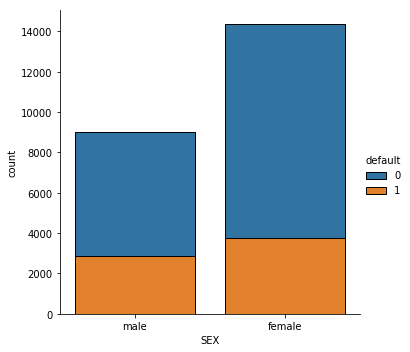

In [54]:
c = sns.catplot(data=df, x='SEX', hue='default', kind='count', dodge=False);
c.set_xticklabels(['male', 'female']);

In [55]:
def_male_sample = df[df.SEX == 1]['default']
def_female_sample = df[df.SEX == 2]['default']

Мы рассматриваем долю мужчин не вернувших кредит среди всех мужчин и долю женщин не вернувших кредит среди всех женщин, взявших кредит.  

Посмотрим на доверительные интервалы для доли невернувших кредиты мужчин и женщин

In [56]:
import statsmodels.stats.proportion as psts

male_confint = psts.proportion_confint(def_male_sample.sum(), len(def_male_sample))
female_confint = psts.proportion_confint(def_female_sample.sum(), len(def_female_sample))
print('Male confint:', male_confint)
print('Female confint:', female_confint, '\n')


Male confint: (0.23397679702375163, 0.2493677521014166)
Female confint: (0.20185432056295824, 0.21367129781160007) 



Мы можем с уверенностью в 95% говорить, что кредит не вернут:  
от 23.38% до 24.94% мужчин  
и от 20.19% до 21.37% женщин

Проверим с помощью z-критерия для доли для двух независимых выборок гипотезу о том, что доли мужчин и женщин невозвращающих кредит равны

**Критерий:**
- z-критерий для доли

**Условия применимости:**
- [X] Биномиальное распределение.

**Гипотезы:**
- $H_0:$ Доли мужчин и женщин невозвращающих кредит равны  
- $H_1: $ $H_0$ неверна 

In [57]:
res = psts.proportions_ztest(
    [def_male_sample.sum(), def_female_sample.sum()],
    [len(def_male_sample), len(def_female_sample)])

print(f'Z-stat: {res[0]:.4f}, p-value: {res[1]}')

Z-stat: 6.9214, p-value: 4.472804335814144e-12


Достигаемый уровень значимости очень мал. Можно с уверенностью отвергнуть нулевую гипотезу о равенстве долей мужчин и женщин, не вернувших кредит.

## Задание 3 . Образование и дефолт
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг?

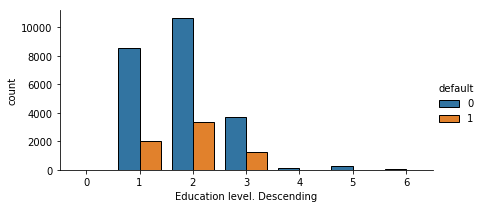

In [43]:
c = sns.catplot(data=df, x='EDUCATION', hue='default', kind='count', aspect=2, height=3);
c.set_xlabels('Education level. Descending');

### Способ 1: Критерий хи-квадрат для корреляции категориальных величин

Проверим корреляцию при помощи критерия хи-квадрат для категориальных величин. Для этого необходимо составить таблицу сопряженности, в ячейках которой будет количество человек, соотвествующего образования вернувших и не вернувших кредит.  

In [59]:
ct = pd.crosstab(df['EDUCATION'], df['default']).T
ct

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


**Критерий:**  
- Критерий хи-квадрат для корреляции категориальных величин

**Условия применимости:** 
 - [X] $n \ge 40$
 - [X] $\frac{n_{i+}n_{+j}}{n} < 5$ in less than 20% cells


In [60]:
ct_check = ct.copy()
for i in range(len(ct.index)):
    for j in range(len(ct.columns)):
        ct_check.loc[i, j] = (ct.loc[i].sum() * ct[j].sum()) / ct.sum().sum()

ct_check < 5

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False


Оба условия выполняются.

**Гипотезы:**  
$H_0:$ выборки `default` и  `EDUCATION` не зависимы.  
$H_1:$ выборки зависимы. Двусторонняя альтернатива.

In [62]:
chistats = sc.stats.chi2_contingency(ct.values)
print(f'Статистика: {chistats[0]:.4f}, p-value: {chistats[1]}')

Статистика: 163.2166, p-value: 1.2332626245415605e-32


На уровне значимости $\alpha=0.05$ нулевую гипотезу об остутствии корреляции между уровнем образования человеком и возвращаемостью кредита можно смело отвергнуть.
То есть образование человека непосредственно влияет на вероятность не вернуть кредит. 

Посчитаем коэффициент корреляции V Крамера чтобы оценить степень корреляции.  
*`proportions_hypotheses` также лежат в одной папке с ноутбуком и здесь: https://github.com/armavox/mldaspec/blob/master/course4/notebooks/proportions_hypotheses.py

In [95]:
import proportions_hypotheses

cramers_v = proportions_hypotheses.cramers_corrected_stat(ct)
print(f"Cramers' V: {cramers_v:.4f}")

### Способ 2: сравнение с равномерным распределением при помощи критерия согласия Пирсона.

Для того чтобы сравнить две выборки необходимо сравнить таблицу сопряженности с аналогичной со значениями извлеченными из равномерного распределения. То есть со случаем, когда вне зависимости от уровня образования среднее количество вернувших и не вернувших кредит одинаково.

In [112]:
# Converting contingency matrix to one-dimension
ct_flat = ct.values.flatten()

# Uniformly distributed contingency matrix.
ct_uniform = np.full(ct_flat.shape, ct_flat.mean())

**Критерий:**  
- Критерий согласия Пирсона

**Условия применимости:**  
- [X] Количество наблюдений в каждом разбиении больше пяти. (В нашем случае только в одной меньше пяти)

**Гипотезы:**   
$H_0:$ распределение образования на возвращении кредита равномерно.  
$H_1:$ $H_0$ неверна. Двусторонняя альтернатива.

In [111]:
sc.stats.chisquare(ct_flat, ct_uniform, ddof=1)

Power_divergenceResult(statistic=71522.4824, pvalue=0.0)

Критерий хи-квадрат отвергает гипотезу о том, что распределение равномерно. Значит корреляция скорее всего есть.

### Визуализация

Чтобы визуализировать степень кредитного доверия к человеку на основе его образования вычислим долю вернувших в своей категории образования. Значения в таблице соответствуютт вероятности вернуть/не вернуть кредит при наличии данного образования.

In [113]:
cont_diff = (ct) / ct.sum()

cont_diff = pd.DataFrame(cont_diff)

cont_diff.columns.names = ['EDUCATION']
cont_diff.index.names = ['default']

cont_diff

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,1.0,0.807652,0.762651,0.748424,0.943089,0.935714,0.843137
1,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863


Можно визуализировать эту таблицу в виде 'heatmap'

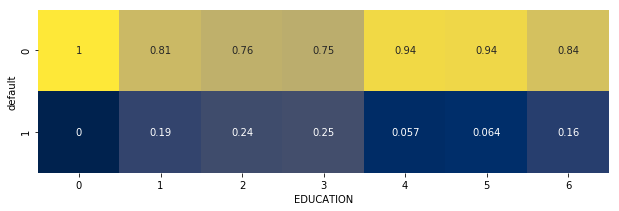

In [125]:
plt.figure(figsize=(12,3))
sns.heatmap(cont_diff, cmap='cividis', annot=True, center=.5, square=True, cbar=False);

## Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

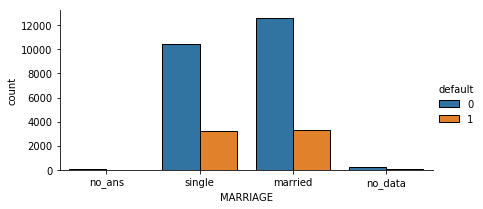

In [28]:
c = sns.catplot(data=df, x='MARRIAGE', hue='default', kind='count', aspect=2, height=3)
c.set_xticklabels(['no_ans', 'single', 'married', 'no_data']);

Примем в рассмотрение только те данные, в которых статус указан.

In [29]:
df_marriage = df[df['MARRIAGE'].isin([1,2])]

Данные – бинарны. В таком случае, чтобы оценить корреляцию, можно воспользоваться критерием **хи-квадрат Мэттьюса: MCC**. Составим таблицу сопряженности для бинарных признаков.

In [30]:
marriage_crosstab = pd.crosstab(df_marriage['MARRIAGE'], df_marriage['default'])
marriage_crosstab

default,0,1
MARRIAGE,,
1,10453,3206
2,12623,3341


In [31]:
def MCC(a, b, c, d):
    num = a*d - b*c
    den = np.sqrt((a+b)*(a+c)*(b+d)*(c+d))
    return num / den

In [32]:
chi2 = marriage_crosstab.sum().sum() * MCC(
                                           marriage_crosstab[0].at[1],
                                           marriage_crosstab[1].at[1],
                                           marriage_crosstab[0].at[2],
                                           marriage_crosstab[1].at[2])**2
sc.stats.chi2.sf(chi2, df=1)

1.44851434298125e-07

**Критерий:**
- хи-квадрат для категориальных величин

**Условия применимости:**
- [X] $n \ge 40$
- [X] $\frac{n_{i+}n_{+j}}{n} < 5$ in less than 20% cells

**Гипотезы:**
- $H_0:$ возвращаемость кредита не зависит от штампа в паспорте против  альтернативы  
- $H_1:$ всё-таки зависит.



In [118]:
marriage_ct_check = marriage_crosstab.copy()
for i in range(len(marriage_ct_check.index)):
    for j in range(len(marriage_ct_check.columns)):
        marriage_ct_check.loc[i, j] = (ct.loc[i].sum() * ct[j].sum()) / ct.sum().sum()

marriage_ct_check < 5

default,0,1
MARRIAGE,,
1,True,False
2,False,False
0,False,False


In [33]:
chistat = sc.stats.chi2_contingency(marriage_crosstab, correction=False)
print(f'Chi statistic: {chistat[0]:.4f};' f'\np-value: {chistat[1]}')

Chi statistic: 27.6569;
p-value: 1.4485143429812136e-07


Для оценки корреляции, посчитаем коэффициент V Крамера

In [106]:
v_cramer_corrcoef = (chistat[0] / marriage_crosstab.sum().sum() * 1)**0.5
print(f"Cramers' V: {v_cramer_corrcoef:.4f}")

Cramers' V: 0.0306


Значение корреляции достаточно мало, чтобы мы могли сказать, что брак не является весомым фактором при принятии решения о выдаче кредита.

## Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 
- a) о равенстве медианных значений возрастов людей 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения?

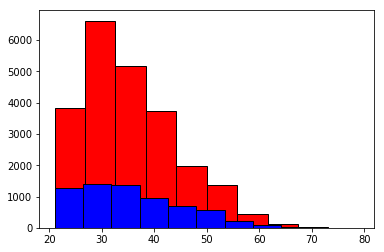

In [34]:
plt.hist(df[df.default == 0].AGE, color='r', bins=10);
plt.hist(df[df.default == 1].AGE, color='b', bins=10);

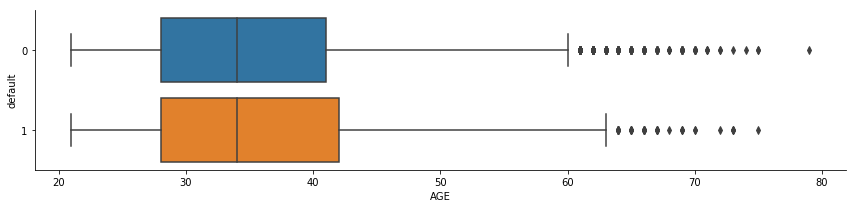

In [35]:
sns.catplot(data=df, x='AGE', y='default', kind='box', orient='h', height=3, aspect=4);

### Гипотеза 1. О равенстве медиан возрастов среди вернувших и не вернувших кредит

Используем опять оценку равенства медиан при помощи интервальных оценок бустрапированной выборки.

In [36]:
def0_age_boot = get_bootstrap_samples(df[df.default == 0].AGE, 1000)
def1_age_boot = get_bootstrap_samples(df[df.default == 1].AGE, 1000)

In [37]:
def0_age_boot_med = np.apply_along_axis(np.median, 1, def0_age_boot)
def1_age_boot_med = np.apply_along_axis(np.median, 1, def1_age_boot)

In [38]:
tolerance_int(def0_age_boot_med - def1_age_boot_med, 0.05)

array([-1.,  0.])

Интервальная оценка на бутстрапированных выборках показывает, что в интервал входит ноль, поэтому отвергнуть нулевую гипотезу о равенстве медианных значений нельзя.

### Гипотеза 2. О равенстве распределений

Для сравнения распределений используем критерий Манна-Уитни. Он не предполагает определенного распределения выборки.  
**Условия применимости:**
- [X]  $n >  40$

**Гипотезы:**
- $H_0: F_{X_1}(x) = F_{X_2}(x)$
- $H_1: F_{X_1}(x) = F_{X_2}(x+\delta)$

Достигаемый уровень значимости критерия Манна-Уитни показывает, что отвергуть нулевую гипотезу нельзя. То есть возраст не является значимым фактором при принятии решения о  выдаче кредита.

In [39]:
sc.stats.mannwhitneyu(
    df[df.default == 0].AGE,
    df[df.default == 1].AGE, 
    alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)